In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import comb
import matplotlib.cm as cm

Let's say we want to study the spectrum of a kernel $K(x,x')$ defined as the spectrum of the integral operator:
$$
(Tf)(\vec x)= \int d^dx' p(\vec x') K(\vec x,\vec x') f(\vec x')
$$
where $p(\vec x)$ is the distribution of the sample space. We assume this corresponds to a multivariate gaussian with mean $0$ and, wlog, diagonal covariance matrix with $\Sigma = diag(\sigma_1^2, \sigma_2^2, \dots)$

In this notebook, we are going to verify the theorems and proposition of [linka il paper giusto]. We will always assume that the kernel is a dot-product kernel, meaning it can be rewritten as:
$$
K(x,x') = h(\langle x, x' \rangle)
$$
with $h \in C^\infty$

### Case 1
Consider the $D$-truncated operator $T_{<D}$ associated to the kernel $K(x,x') = \sum_{m=0}^D h_m \langle x,x'\rangle^m$. Proposition 1 claims that we can index its eigenvalues with a multi-index $\beta = (\beta_1, \beta_2, ..., \beta_d)$ such that $|\beta| = \sum_j \beta_j \leq D$. By simple means of combinatorics, there should be a total of $d+D \choose D$ eigenvalues obeying the relation:
$$
C_{1,\beta} \sigma_1^{\beta_1} \dots  \sigma_d^{\beta_d} \leq \lambda_\beta \leq C_{2,\beta} \sigma_1^{\beta_1} \dots  \sigma_d^{\beta_d} 
$$

Let's try and verify empirically this statement

---

To extract the eigenvalues of a continuous operator, we can perform an empirical diagonalization (described in another notebook). Let's take, as an example, the $5$-truncated kernel associated to $h(t) = e^t$, i.e.:
$$
K_{\leq D}(x,x') = 1 + \langle x, x'\rangle + \frac{1}{2}\langle x, x'\rangle^2 + \frac{1}{6}\langle x, x'\rangle^3 + \frac{1}{24}\langle x, x'\rangle^4 + \frac{1}{120}\langle x, x'\rangle^5
$$
The eigenvalues $\lambda_\beta$ of $T_{\leq D}$ can be numerically estimated by first building the empirical kernel matrix $\tilde K(x,x')$:
$$
\tilde K (x_i,x_j) = \frac{1}{M} (1 + \langle x_i, x_j \rangle + \frac{1}{2}\langle x_i, x_j\rangle^2 + \frac{1}{6}\langle x_i, x_j\rangle^3 + \frac{1}{24}\langle x_i, x_j\rangle^4 + \frac{1}{120}\langle x_i, x_j\rangle^5)
$$
where $x_i, x_j$ are sampled from the pdf $p(x)$ and there are $M$ of them. Let's fix the dimension $d = 10$. Then we should expect a total of ${10+5 \choose 5} = 3003$ eigenvalues

Let us first consider a case where data are isotropic. This means that:
$$
C_{1,\beta} \sigma^{|\beta|}  \leq \lambda_\beta \leq C_{2,\beta} \sigma^{|\beta|}
$$
Hence, assuming $C_{1,\beta} \approx C_{2,\beta} \approx C_{|\beta|}$, we can write:
$$
\lambda_\beta \approx C_{|\beta|} \sigma^{|\beta|}
$$
Hence, we should observe a degeneracy for each degree $m = |\beta|$

To estimate how many eigenvalues we should measure at a fixed degree $m = |\beta| \leq D$, we can leverage again the combinatorics. We have to count the number of vectors $\beta_1, \beta_2, ..., \beta_d$ such that the sum $\beta = m$. This is precisely ${m+d-1 \choose d-1}$

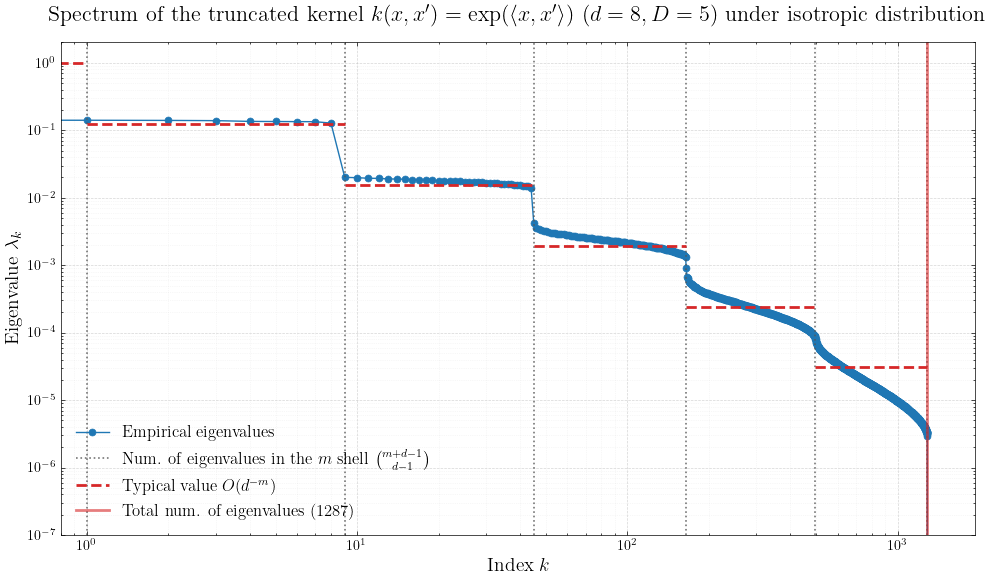

In [ ]:
d = 8
D = 5   
coefficient = [1, 1, 0.5, 1/6, 1/24, 1/120] 

Ms = [10000]

sigma = 0.8
Sigma = np.diag([sigma/(1) for i in range(d)])
Sigma = Sigma / (np.trace(Sigma))

plt.figure(figsize=(10, 6), dpi=100) 

for M in Ms:
    X = np.random.multivariate_normal(np.zeros(d), Sigma, M)
    Gram = X @ X.T 
    K = np.zeros((M, M))
    for power, c in enumerate(coefficient):
        K += c * (Gram ** power)
    K = K / M
    
    eigenvalues = np.linalg.eigvalsh(K)
    eigenvalues = np.sort(eigenvalues)[::-1]

    plt.plot(range(len(eigenvalues)), eigenvalues, 
             marker='o', 
             markersize=5,
             markeredgewidth=0.5,
             color='#1f77b4',     
             alpha=1, 
             linestyle='-', 
             linewidth=1,
             label='Empirical eigenvalues')

    cumulative = 0
    for _ in range(len(coefficient)):
        cumulative += comb(_ + d - 1, d - 1, exact=True)
        plt.axvline(x=cumulative, 
                    color='#555555',       
                    linestyle=':', 
                    linewidth=1.2,
                    alpha=0.8, 
                    label=r'Num. of eigenvalues in the $m$ shell $m+d-1 \choose d-1$' if _ == 0 else None)
        plt.hlines(y=pow(d, -_), xmin=cumulative - comb(_ + d - 1, d - 1, exact=True), xmax=cumulative,
                    color='#d62728',    
                    linestyle='--', 
                    linewidth=2, 
                    label=r'Typical value $O(d^{-m})$' if _ == 0 else None)

    n_theoretical = comb(d + D, D)
    plt.axvline(x=n_theoretical, color='#d62728', linestyle='-', linewidth=2, alpha=0.6, label=f'Total num. of eigenvalues ({int(n_theoretical)})')
    plt.title(rf"Spectrum of the truncated kernel $k(x, x') = \exp(\langle x, x' \rangle)$ ($d={d}, D={D}$) under isotropic distribution", fontsize=16, pad=15)
    plt.xlabel(r'Index $k$', fontsize=14)
    plt.ylabel(r'Eigenvalue $\lambda_k$', fontsize=14)
    
    plt.xscale('log')
    plt.yscale('log')
    plt.xlim(0.8, n_theoretical * 1.5)
    plt.ylim(1e-7, 2)
    
    plt.legend(fontsize=12, loc='lower left', framealpha=0.9, shadow=True)
    plt.grid(True, which='major', linestyle='--', alpha=0.6, color='#bbbbbb')
    plt.grid(True, which='minor', linestyle=':', alpha=0.3, color='#cccccc')

plt.savefig('spectrum_isotropic.pdf', dpi=300)
plt.tight_layout()
plt.show()

When $\alpha = 0$, I should have $C_{1,\beta} = C_{2,\beta}$ because of the intrinsic symmetry of the problem. Hence, I should observe a "staircase" spectrum.

Here, the behavior is less steep because of $M$ which is finite. I'm using empirical diagonalization which converges as $M\to\infty$. Maybe there are better ways to approximate the spectrum? This is a MC method, it converges slowly ($1 / \sqrt{M}$)

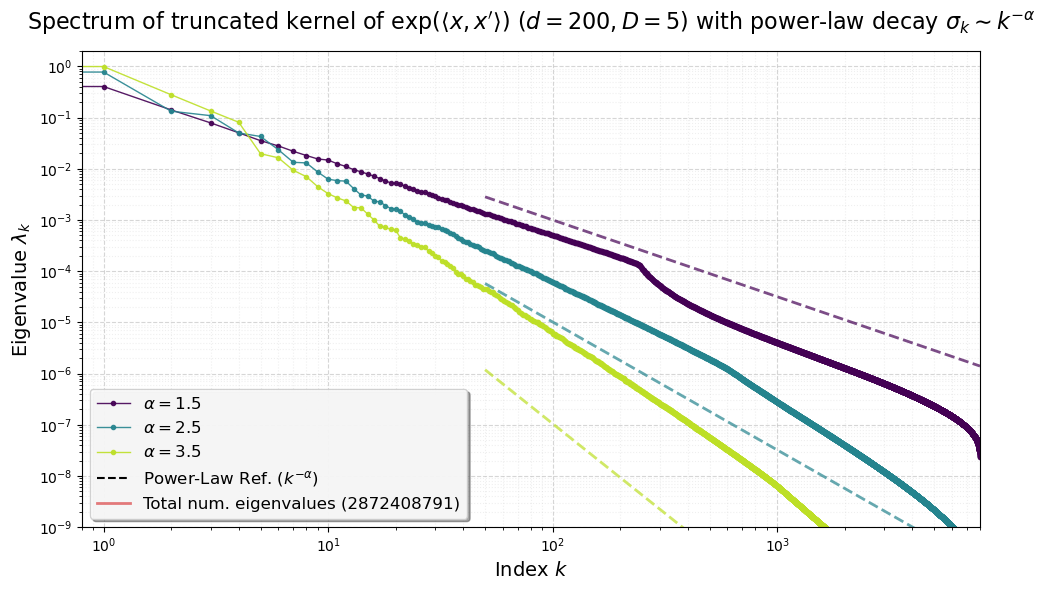

In [2]:
d = 200
D = 5   
coefficient = [1, 1, 0.005, 0.005, 0.005,0.0004] 

M = 8000
alphas = [1.5, 2.5, 3.5]

# Setup colori
colors = cm.viridis(np.linspace(0, 0.9, len(alphas)))

plt.figure(figsize=(10, 6), dpi=100) 

# --- PRIMO LOOP: DATI EMPIRICI (Con Label) ---
max_eig_per_alpha = [] # Salviamo il max per allineare la teoria dopo

for idx, alpha in enumerate(alphas):
    if alpha == 0:
        Sigma = np.eye(d)
    else:
        Sigma = np.diag([1.0/(i+1)**alpha for i in range(d)])

    Sigma = Sigma / (np.trace(Sigma))
    
    X = np.random.multivariate_normal(np.zeros(d), Sigma, M)
    Gram = X @ X.T 
    K = np.zeros((M, M))
    for power, c in enumerate(coefficient):
        K += c * (Gram ** power)
    K = K / M
    
    eigenvalues = np.linalg.eigvalsh(K)
    eigenvalues = np.sort(eigenvalues)[::-1]
    
    max_eig_per_alpha.append(eigenvalues[0]) # Salviamo il primo autovalore

    # QUI mettiamo la label, così appare nella legenda
    plt.plot(range(len(eigenvalues)), eigenvalues, 
             marker='o', 
             markersize=3,
             color=colors[idx],     
             alpha=0.9, 
             linestyle='-', 
             linewidth=1.0,
             label=rf'$\alpha = {alpha}$')

# --- SECONDO LOOP: LINEE TEORICHE (Senza Label) ---
x_ref = np.linspace(50, M, 100)

for i, alpha in enumerate(alphas):
    # Calcolo altezza corretta per sovrapporre (euristico: allinea al primo punto)
    # y = C * x^-alpha. Se x=1, y=C. Quindi C = primo_autovalore
    y_ref = max_eig_per_alpha[i] * (x_ref ** (-alpha))
    
    # RIMOSSA la 'label' qui per evitare duplicati nella legenda
    plt.plot(x_ref, y_ref, 
             color=colors[i], # Usa color=... esplicito
             linestyle='--', 
             linewidth=2.0, 
             alpha=0.7) 
             # Niente label!

# Aggiungiamo UNA sola voce nera finta per spiegare cos'è la linea tratteggiata
plt.plot([], [], color='black', linestyle='--', label='Power-Law Ref. ($k^{-\\alpha}$)')

n_theoretical = comb(d + D, D)
plt.axvline(x=n_theoretical, color='#d62728', linestyle='-', linewidth=2, alpha=0.6, label=f'Total num. eigenvalues ({int(n_theoretical)})')

# Titoli e Assi
plt.title(rf"Spectrum of truncated kernel of $\exp(\langle x,x' \rangle)$ ($d={d}, D={D}$) with power-law decay $\sigma_k \sim k^{{-\alpha}}$", fontsize=16, pad=15)
plt.xlabel(r'Index $k$', fontsize=14)
plt.ylabel(r'Eigenvalue $\lambda_k$', fontsize=14)

plt.xscale('log')
plt.yscale('log')
plt.xlim(0.8, M)
plt.ylim(1e-9, 2)

plt.legend(fontsize=12, loc='lower left', framealpha=0.9, shadow=True)
plt.grid(True, which='major', linestyle='--', alpha=0.6, color='#bbbbbb')
plt.grid(True, which='minor', linestyle=':', alpha=0.3, color='#cccccc')

#plt.savefig('spectrum_exp_alpha>1.pdf', dpi=300)
plt.tight_layout()
plt.show()

1
41
861
12341
135751
1221759


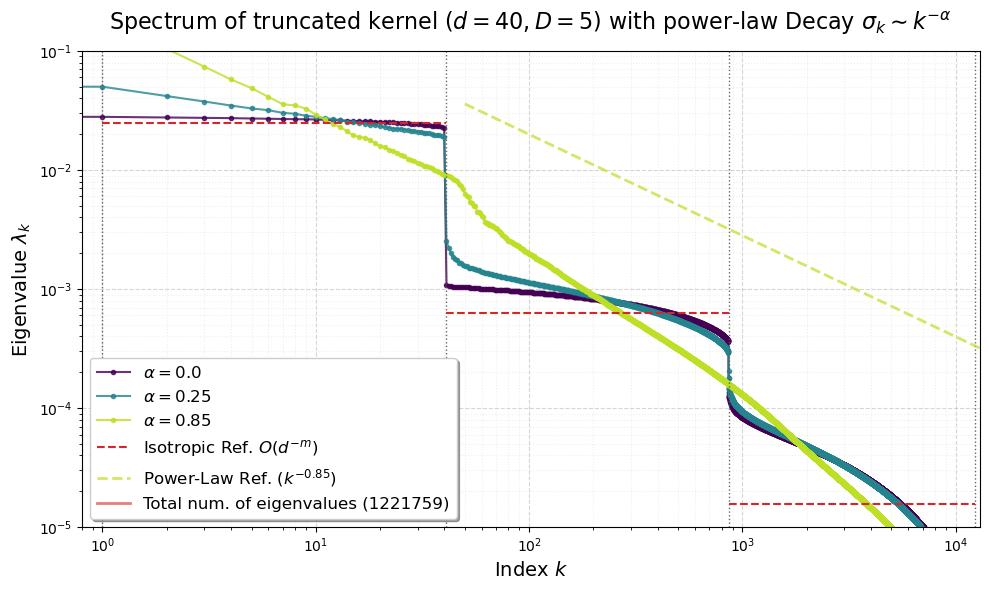

In [6]:
d = 40
D = 5   
coefficient = [1, 1, 0.5, 1/6, 1/24, 1/120] 

M = 13000
alphas = [0.0, 0.25, 0.85]
sigma = 0.8

# Setup colori
colors = cm.viridis(np.linspace(0, 0.9, len(alphas)))

plt.figure(figsize=(10, 6), dpi=100) 

for idx, alpha in enumerate(alphas):
    if alpha == 0:
        Sigma = np.eye(d)
    else:
        Sigma = np.diag([1.0/(i+1)**alpha for i in range(d)])

    Sigma = Sigma / (np.trace(Sigma))
    
    X = np.random.multivariate_normal(np.zeros(d), Sigma, M)
    Gram = X @ X.T 
    K = np.zeros((M, M))
    for power, c in enumerate(coefficient):
        K += c * (Gram ** power)
    K = K / M
    
    eigenvalues = np.linalg.eigvalsh(K)
    eigenvalues = np.sort(eigenvalues)[::-1]

    plt.plot(range(len(eigenvalues)), eigenvalues, 
             marker='o', 
             markersize=3,
             color=colors[idx],     
             alpha=0.8, 
             linestyle='-', 
             linewidth=1.5,
             label=rf'$\alpha = {alpha}$')

cumulative = 0
for _ in range(len(coefficient)):
    cumulative += comb(_ + d - 1, d - 1, exact=True)
    
    # Linee Verticali (Cutoff gradi)
    plt.axvline(x=cumulative, 
                color='#555555',       
                linestyle=':', 
                linewidth=1,
                alpha=0.9)
    print(cumulative)
    plt.hlines(y=pow(d, -_), xmin=cumulative - comb(_ + d - 1, d - 1, exact=True), xmax=cumulative,
                color='#d62728',    
                linestyle='--', 
                linewidth=1.5, 
                label=r'Isotropic Ref. $O(d^{-m})$' if _ == 0 else None)
# a reference line for power law decay
x_ref = np.linspace(50, M, 100)
y_ref = (x_ref ** (-0.85))

# RIMOSSA la 'label' qui per evitare duplicati nella legenda
plt.plot(x_ref, y_ref, 
            color=colors[2], # Usa color=... esplicito
            linestyle='--', 
            linewidth=2.0, 
            alpha=0.7, label = 'Power-Law Ref. ($k^{-0.85}$)') 
            # Niente label!
n_theoretical = comb(d + D, D)
plt.axvline(x=n_theoretical, color='#d62728', linestyle='-', linewidth=2, alpha=0.6, label=f'Total num. of eigenvalues ({int(n_theoretical)})')

# Titoli e Assi
plt.title(rf"Spectrum of truncated kernel ($d={d}, D={D}$) with power-law Decay $\sigma_k \sim k^{{-\alpha}}$", fontsize=16, pad=15)
plt.xlabel(r'Index $k$', fontsize=14)
plt.ylabel(r'Eigenvalue $\lambda_k$', fontsize=14)

plt.xscale('log')
plt.yscale('log')
plt.xlim(0.8, M)
plt.ylim(1e-5, 0.1)
plt.legend(fontsize=12, loc='lower left', 
           frameon=True,       # Bordo attivo
           framealpha=1,       # Sfondo opaco (copre la griglia)
           facecolor='white',  # Colore bianco
           shadow=True,        # Ombra attiva
           fancybox=True)      # Angoli arrotondati

plt.grid(True, which='major', linestyle='--', alpha=0.6, color='#bbbbbb')
plt.grid(True, which='minor', linestyle=':', alpha=0.3, color='#cccccc')

plt.savefig('spectrum_exp_alpha<1_part2.pdf', dpi=300)

plt.tight_layout()
plt.show()